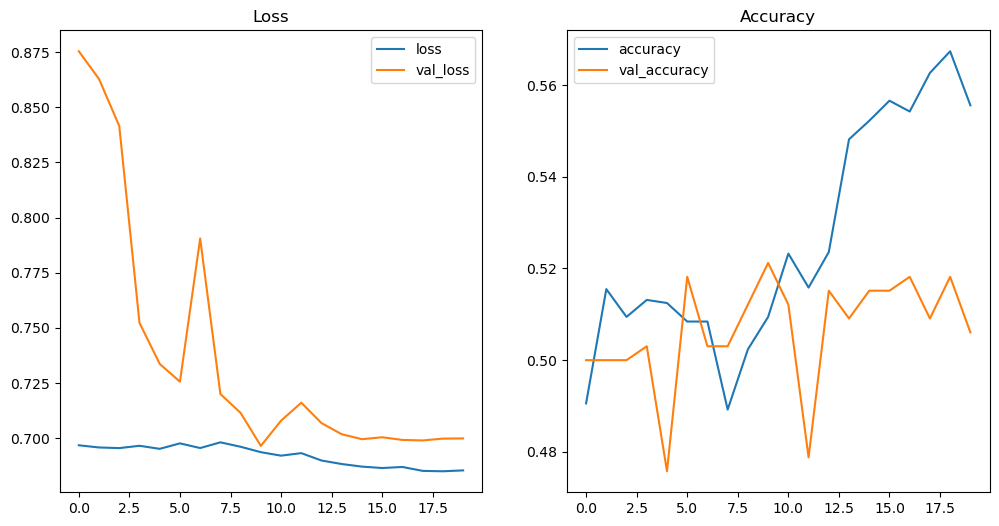

99/99 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5657 - loss: 0.6825 - val_accuracy: 0.5061 - val_loss: 0.6999 - learning_rate: 3.0000e-05


In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization, Add, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Function to preprocess an image with edge detection and line broadening
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img = img_to_array(img).astype('uint8')
    
    # Apply edge detection
    edges = cv2.Canny(img, threshold1=30, threshold2=100)
    
    # Dilate the edges to broaden the lines
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Normalize the image
    edges = edges / 255.0
    edges = np.expand_dims(edges, axis=-1)
    
    return edges

# Function to load images from a folder
def load_images_from_folder(folder, augmentation=False):
    images = []
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                 shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest') if augmentation else None

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = preprocess_image(img_path)
        if img is not None:
            if augmentation:
                img = np.expand_dims(img, axis=0)
                for batch in datagen.flow(img, batch_size=1):
                    images.append(batch[0])
                    break
            else:
                images.append(img)

    return np.array(images)

# Function to load datasets
def load_datasets(base_path, augmentation=False):
    all_images = []
    all_labels = []
    
    for i in range(1, 70):
        if i in [5, 7, 8, 10, 11]:
            continue
        real_folder = os.path.join(base_path, f'{i:03}')
        forge_folder = os.path.join(base_path, f'{i:03}_forg')
        
        real_images = load_images_from_folder(real_folder, augmentation)
        forge_images = load_images_from_folder(forge_folder, augmentation)
        
        images = np.concatenate((real_images, forge_images), axis=0)
        labels = np.array([1] * len(real_images) + [0] * len(forge_images))
        
        all_images.append(images)
        all_labels.append(labels)
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_images, all_labels

# Function to load test datasets
def load_datasets_test(base_path, augmentation=False):
    all_images = []
    all_labels = []
    
    for i in range(49, 70):
        real_folder = os.path.join(base_path, f'{i:03}')
        forge_folder = os.path.join(base_path, f'{i:03}_forg')
        
        real_images = load_images_from_folder(real_folder, augmentation)
        forge_images = load_images_from_folder(forge_folder, augmentation)
        
        images = np.concatenate((real_images, forge_images), axis=0)
        labels = np.array([1] * len(real_images) + [0] * len(forge_images))
        
        all_images.append(images)
        all_labels.append(labels)
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_images, all_labels

# Base path to the datasets
train_path = 'sign_data/train'
test_path = 'sign_data/test'

# Load and normalize datasets
train_images, train_labels = load_datasets(train_path, augmentation=True)
test_images, test_labels = load_datasets_test(test_path, augmentation=False)

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

# Define the custom CNN model
def build_custom_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    def conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation='relu')(x)
        x = BatchNormalization()(x)
        return x
    
    def residual_block(x, filters):
        residual = Conv2D(filters, (1, 1), padding='same')(x)  # Adjust dimensions with a 1x1 convolution
        residual = BatchNormalization()(residual)
        x = conv_block(x, filters)
        x = conv_block(x, filters)
        x = Add()([x, residual])
        return x

    def inception_block(x, filters):
        tower_1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
        tower_1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(tower_1)
        
        tower_2 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
        tower_2 = Conv2D(filters, (5, 5), padding='same', activation='relu')(tower_2)
        
        tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        tower_3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(tower_3)
        
        output = concatenate([tower_1, tower_2, tower_3], axis=3)
        return output

    # Initial Convolution Layer
    x = conv_block(inputs, 32)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Residual and Inception Blocks
    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = inception_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = inception_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    model = Model(inputs, x)
    
    return model

# Custom function for the Lambda layer
def custom_cosine_similarity(vectors):
    x, y = vectors
    x = tf.nn.l2_normalize(x, axis=-1)
    y = tf.nn.l2_normalize(y, axis=-1)
    return -tf.reduce_sum(x * y, axis=-1, keepdims=True)

# Define the Siamese network
def siamese_model(base_model, input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)
    L1_layer = Lambda(custom_cosine_similarity)([processed_a, processed_b])
    prediction = Dense(1, activation='sigmoid')(L1_layer)
    model = Model(inputs=[input_a, input_b], outputs=prediction)
    return model

input_shape = (128, 128, 1)  # Adjust the input shape as needed
base_model = build_custom_cnn_model(input_shape)
siamese_net = siamese_model(base_model, input_shape)

siamese_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Function to generate pairs of images for training
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]
    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        # Positive Pair
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append(1)
        # Negative Pair
        neg_label = np.random.choice(list(set(range(num_classes)) - set([label])))
        idxB = np.random.choice(idx[neg_label])
        neg_image = images[idxB]
        pair_images.append([current_image, neg_image])
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

pairs_train, labels_train = make_pairs(X_train, y_train)
pairs_val, y_val = make_pairs(X_val, y_val)
pairs_test, labels_test = make_pairs(test_images, test_labels)

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 6))
        display(self.fig)

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1

        clear_output(wait=True)

        self.ax[0].clear()
        self.ax[0].plot(self.x, self.losses, label="loss")
        self.ax[0].plot(self.x, self.val_losses, label="val_loss")
        self.ax[0].legend()
        self.ax[0].set_title('Loss')

        self.ax[1].clear()
        self.ax[1].plot(self.x, self.acc, label="accuracy")
        self.ax[1].plot(self.x, self.val_acc, label="val_accuracy")
        self.ax[1].legend()
        self.ax[1].set_title('Accuracy')

        display(self.fig)
        plt.pause(0.01)

plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00003)

# Train the model
history = siamese_net.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train, 
    validation_data=([pairs_val[:, 0], pairs_val[:, 1]], y_val), 
    batch_size=30, epochs=50, 
    callbacks=[early_stopping, reduce_lr, plot_losses]
)




In [2]:
siamese_net.save('custom_signet_model_augmented_b16.keras')

# Function to evaluate the genuineness of two signatures
def evaluate_signature(img1_path, img2_path):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    prediction = siamese_net.predict([img1, img2])
    return prediction[0][0] * 100


In [6]:

# Example usage
fake_img_path = 'img2.jpeg'
real_img_path = 'img4.jpeg'
genuineness = evaluate_signature(fake_img_path, real_img_path)

if genuineness > 70:
    print(f"Genuine: {genuineness:.2f}%")
else:
    print(f"Fraud: {genuineness:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Genuine: 70.41%
